# Get data on flights & set up a connection to our SQL database.

### import libraries & functions

In [3]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import psycopg2 # needed to get database exception errors when uploading dataframe
import requests # package for getting data from the web
from zipfile import * # package for unzipping zip files
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Import the get_engine function from our sql_functions.
from sql_functions import get_engine #adjust this as necessary to match your sql_functions.py connection methods
from sql_functions import get_dataframe

## 1. Download csv file with flight data for your specific year/month

In [ ]:
# Specifies path for saving file
path ='data/' 
# Create the data folder
#!mkdir {path}

In [ ]:
# function to get specified csv file from the website https://transtats.bts.gov

def download_data(year, month):
    # Get the file from the website https://transtats.bts.gov
    zip_file = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
    url = (f'https://transtats.bts.gov/PREZIP/{zip_file}')
    # Download the database
    r = requests.get(f'{url}', verify=False)
    # Save database to local file storage
    with open(path+zip_file, 'wb') as f:
        f.write(r.content)
        print(f'--> zip_file with name: {zip_file} downloaded succesfully.' )

#download_data(2005,8)
    

In [ ]:
# function to extract the csv files inside the zip files

def extract_zip(year, month):
    # Get the file from the website https://transtats.bts.gov
    zip_file = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
    with ZipFile(path+zip_file, 'r') as zip_ref:
        zip_ref.extractall(path)
        csv_file =  zip_ref.namelist()[0]
        print(f'--> zip_file was succesfully extracted to: {csv_file}.' )

#extract_zip(2005,8)

In [ ]:
# years_list = [2020, 2021] # list of years you want to look at (can of course also be a single year)
# months_list = [1, 2] # list of months you want to look at (can of course also be a single month)

# download flights data as zipfile(s)
# we use a nested loop to specify the years and months to define the range of the data we would like to have 
#for year in years_list:
#    for month in months_list:
#        download_data(year, month)
#        extract_zip(year, month)

In [ ]:
# define the name of the csv file you want to read in
csv_file = 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2005_8.csv'

# Read in your data
df = pd.read_csv(path+csv_file, low_memory = False)
display(df.shape)
display(df.head())

## 2. Prepare the csv file for further processing

In [ ]:
# Columns from downloaded file that are to be kept

columns_to_keep = [
                'FlightDate',
                'DepTime',
                'CRSDepTime',
                'DepDelay',
                'ArrTime',
                'CRSArrTime',
                'ArrDelay',
                'Reporting_Airline',
                'Tail_Number',
                'Flight_Number_Reporting_Airline',
                'Origin',
                'Dest',
                'AirTime',
                'ActualElapsedTime',
                'Distance',
                'Cancelled',
                'Diverted'
]

In [ ]:
# The columns in the database have different naming as in the source csv files. Lets get the names from the database

schema = 'cgn_analytics_22_3' # UPDATE 'TABLE_SCHEMA' based on schema used in class 
engine = get_engine() # assign engine to be able to query against the database

table_name_sql = f'''SELECT COLUMN_NAME 
                    FROM INFORMATION_SCHEMA.COLUMNS 
                    WHERE TABLE_NAME = 'flights'
                    AND TABLE_SCHEMA ='{schema}'
                    ORDER BY ordinal_position'''
c_names = engine.execute(table_name_sql).fetchall()
c_names

In [ ]:
# we can clean up the results into a clean list
new_column_names=[]
for name in c_names:
    new_column_names.append(name[0])
new_column_names        

### Make our csv file ready to be uploaded to SQL (We only keep to above specified columns and convert the datatypes.)

In [ ]:
def clean_airline_df(df):
    '''
    Transforms a df made from BTS csv file into a df that is ready to be uploaded to SQL
    Set rows=0 for no filtering
    '''

    # Build dataframe including only the columns you want to keep
    df_airline = df.loc[:,columns_to_keep]
     
    # Clean data types and NULLs
    df_airline['FlightDate']= pd.to_datetime(df_airline['FlightDate'], yearfirst=True)
    df_airline['CRSArrTime']= pd.to_numeric(df_airline['CRSArrTime'], downcast='integer', errors='coerce')
    df_airline['Cancelled']= pd.to_numeric(df_airline['Cancelled'], downcast='integer')
    df_airline['Diverted']= pd.to_numeric(df_airline['Diverted'], downcast='integer')
    df_airline['ActualElapsedTime']= pd.to_numeric(df_airline['ActualElapsedTime'], downcast='integer', errors='coerce')
    
    # Rename columns
    df_airline.columns = new_column_names
    
    return df_airline

In [ ]:
# Call function and check resulting dataframe
df_clean = clean_airline_df(df)
df_clean.head()

In [ ]:
# Specify the airports you are interested in and put them as a list in the function.
def select_airport(df, airports):
    ''' Helper function for filtering the airline dataframe for a subset of airports'''
    df_out = df.loc[(df.origin.isin(airports)) | (df.dest.isin(airports))]
    return df_out

In [ ]:
# Execute function, filtering for New York area airports
airports=['MSY', 'BTR', 'GPT', 'MOB', 'PNS', 'VPS']
if len(airports) > 0:
    df_selected_airports = select_airport(df_clean, airports)
else:
    df_selected_airports = df_clean
    
df_selected_airports.head()

## 3. Push the prepared data to a table in the database

In [ ]:
# Specify which table within your database you want to push your data to. Give your table an unambiguous name.
# Example: flights_sp for Sina's flights table, flights_groupname or similar
table_name = 'flights_katrina'
# If the specified table doesn't exist yet, it will be created
# With 'replace', your data will be replaced if the table already exists.
# This may take some time ...

# Write records stored in a dataframe to SQL database
# if engine!=None:
#     try:
#         df_selected_airports.to_sql(name=table_name, # Name of SQL table
#                         con=engine, # Engine or connection
#                         if_exists='replace', # Drop the table before inserting new values 
#                         schema=schema, # Use schmea that was defined earlier
#                         index=False, # Write DataFrame index as a column
#                         chunksize=5000, # Specify the number of rows in each batch to be written at a time
#                         method='multi') # Pass multiple values in a single INSERT clause
#         print(f"The {table_name} table was imported successfully.")
#     # Error handling
#     except (Exception, psycopg2.DatabaseError) as error:
#         print(error)
#         engine = None

In [ ]:
# Just to be sure: Check if the number of rows match
table_name_sql = f'''SELECT count(*) 
                    FROM {schema}.{table_name}
                    '''
engine.execute(table_name_sql).fetchall()[0][0] == df_selected_airports.shape[0]

# EDA

## flights

In [22]:
flights_katrina = get_dataframe('SELECT * FROM cgn_analytics_22_3.flights_katrina')
flights_katrina.info()
flights_katrina.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16331 entries, 0 to 16330
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   flight_date          16331 non-null  datetime64[ns]
 1   dep_time             14565 non-null  float64       
 2   sched_dep_time       16331 non-null  int64         
 3   dep_delay            14565 non-null  float64       
 4   arr_time             14444 non-null  float64       
 5   sched_arr_time       16331 non-null  int64         
 6   arr_delay            14444 non-null  float64       
 7   airline              16331 non-null  object        
 8   tail_number          15286 non-null  object        
 9   flight_number        16331 non-null  int64         
 10  origin               16331 non-null  object        
 11  dest                 16331 non-null  object        
 12  air_time             14444 non-null  float64       
 13  actual_elapsed_time  14444 non-

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,actual_elapsed_time,distance,cancelled,diverted
0,2005-08-20,1217.0,1125,52.0,1440.0,1349,51.0,DL,N998DL,1013,MSY,ATL,67.0,83.0,425.0,0,0
1,2005-08-20,1928.0,1930,-2.0,2147.0,2159,-12.0,DL,N922DL,1023,MSY,ATL,62.0,79.0,425.0,0,0
2,2005-08-20,723.0,725,-2.0,947.0,1006,-19.0,DL,N909DA,1024,MSY,SLC,182.0,204.0,1428.0,0,0
3,2005-08-20,1214.0,1215,-1.0,1223.0,1232,-9.0,DL,N319DL,1090,ATL,GPT,50.0,69.0,352.0,0,0
4,2005-08-20,1120.0,1116,4.0,1125.0,1123,2.0,DL,N984DL,1100,ATL,VPS,41.0,65.0,250.0,0,0


### Let's seperate the data (Katrina occured from 23-08-2005 to 31-08-2005)

In [ ]:
before_katrina = flights_katrina[(flights_katrina['flight_date'] <= '2005-08-22')]
during_katrina = flights_katrina[(flights_katrina['flight_date'] >= '2005-08-23')]

Hypotheses:
- Air Time increases
- Departure delay increases
- Cancelled flights increase

In [ ]:
air_time_mean = round(before_katrina.air_time.mean(), 2)
dep_delay_mean = round(before_katrina.dep_delay.mean(), 2)
cancelled_mean = round(before_katrina.cancelled.mean()*100, 2)

print(f'mean air_time before Katrina =', air_time_mean, f'min')
print(f'mean dep_delay before Katrina =', dep_delay_mean, f'min')
print(f'mean cancelled before Katrina =', cancelled_mean, f'%')

mean air_time before Katrina = 82.39 min
mean dep_delay before Katrina = 12.32 min
mean cancelled before Katrina = 2.24 %


In [ ]:
air_time_katrina = round(during_katrina.air_time.mean(), 2)
dep_delay_katrina = round(during_katrina.dep_delay.mean(), 2)
cancelled_katrina = round(during_katrina.cancelled.mean()*100, 2)

print(f'mean air_time during Katrina =', air_time_katrina, f'min')
print(f'mean dep_delay during Katrina =', dep_delay_katrina, f'min')
print(f'mean cancelled during Katrina =', cancelled_katrina, f'%')

mean air_time during Katrina = 79.99 min
mean dep_delay during Katrina = 7.48 min
mean cancelled during Katrina = 32.05 %


In [ ]:
# cancelled & diverted flights result in NaN of air_time

airtime_nan_bk = before_katrina['air_time'].isna().sum()
airtime_nan_dk = during_katrina['air_time'].isna().sum()

print(f'NaN in air_time before Katrina =', airtime_nan_bk)
print(f'NaN in air_time during Katrina =', airtime_nan_dk)

NaN in air_time before Katrina = 290
NaN in air_time during Katrina = 1597


In [ ]:
# cancelled flights result in NaN of dep_delay

depdelay_nan_bk = before_katrina['dep_delay'].isna().sum()
depdelay_nan_dk = during_katrina['dep_delay'].isna().sum()

print(f'NaN in dep_delay before Katrina =', depdelay_nan_bk)
print(f'NaN in dep_delay during Katrina =', depdelay_nan_dk)

NaN in dep_delay before Katrina = 260
NaN in dep_delay during Katrina = 1506


In [ ]:
cancelled_bk = (before_katrina['cancelled'] == 1).sum()
cancelled_dk = (during_katrina['cancelled'] == 1).sum()

print(f'cancelled flights before Katrina =', cancelled_bk)
print(f'cancelled flights during Katrina =', cancelled_dk)

cancelled flights before Katrina = 260
cancelled flights during Katrina = 1506


In [ ]:
diverted_bk = (before_katrina['diverted'] == 1).sum()
diverted_dk = (during_katrina['diverted'] == 1).sum()

print(f'diverted flights before Katrina =', diverted_bk)
print(f'diverted flights during Katrina =', diverted_dk)

diverted flights before Katrina = 30
diverted flights during Katrina = 91


In [ ]:
flights_by_date = flights_katrina.groupby('flight_date').sum().drop(flights_katrina.columns[[1, 2, 3, 4, 5, 6, 9, 12, 13, 14]], axis=1).reset_index()
flights_by_date

,flight_date,cancelled,diverted
0,2005-08-01,5,1
1,2005-08-02,4,1
2,2005-08-03,3,1
3,2005-08-04,6,2
4,2005-08-05,8,0
5,2005-08-06,7,1
6,2005-08-07,8,2
7,2005-08-08,14,1
8,2005-08-09,36,1
9,2005-08-10,19,0


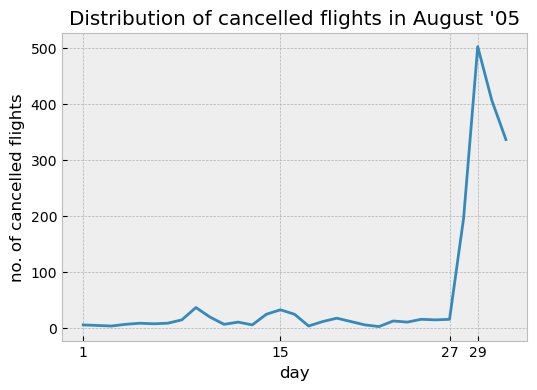

In [ ]:
plt.style.use('bmh') 

plt.figure(figsize=(6, 4))

plt.plot(flights_by_date['cancelled'])

plt.xlabel('day')
plt.ylabel('no. of cancelled flights')

plt.xticks([0, 14, 26, 28], ['1', '15', '27', '29'])

plt.title("Distribution of cancelled flights in August '05")

plt.show();

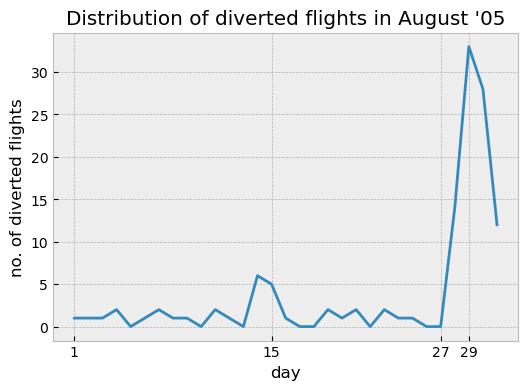

In [ ]:
plt.style.use('bmh') 

plt.figure(figsize=(6, 4))

plt.plot(flights_by_date['diverted'])

plt.xlabel('day')
plt.ylabel('no. of diverted flights')

plt.xticks([0, 14, 26, 28], ['1', '15', '27', '29'])

plt.title("Distribution of diverted flights in August '05")

plt.show();

## weather

distance from furthest to closest to the core of Katrina:

    VPS
    PNS
    MOB
    GPT
    BTR
    MSY

Checked tables in DBeaver, distance doesn't neccessarily result in lower intensity

In [21]:
weather_katrina = get_dataframe('SELECT * FROM cgn_analytics_22_3.group_1_weather_hourly')
weather_katrina.info()
weather_katrina.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4464 entries, 0 to 4463
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              4464 non-null   object 
 1   temp_celsius      4373 non-null   float64
 2   wind_speed_kph    4373 non-null   float64
 3   air_pressure_hPa  4423 non-null   float64
 4   airport_code      4464 non-null   object 
dtypes: float64(3), object(2)
memory usage: 174.5+ KB


,date,temp_celsius,wind_speed_kph,air_pressure_hPa,airport_code
0,2005-08-01,28.9,9.4,1015.1,MSY
1,2005-08-01,28.3,5.4,1015.8,MSY
2,2005-08-01,28.3,0.0,1016.1,MSY
3,2005-08-01,26.7,5.4,1016.1,MSY
4,2005-08-01,25.6,0.0,1016.2,MSY


### Let's seperate the data (Katrina occured from 23-08-2005)

In [ ]:
weather_before_katrina = weather_katrina[(weather_katrina['date'] <= '2005-08-22')]
weather_during_katrina = weather_katrina[(weather_katrina['date'] >= '2005-08-23')]

In [ ]:
wind_speed_mean = round(weather_before_katrina.wind_speed_kph.mean(), 2)
wind_speed_katrina = round(weather_during_katrina.wind_speed_kph.mean(), 2)

print(f'mean wind_speed before Katrina =', wind_speed_mean, f'km/h')
print(f'mean wind_speed during Katrina =', wind_speed_katrina, f'km/h')

mean wind_speed before Katrina = 7.04 km/h
mean wind_speed during Katrina = 15.15 km/h


In [ ]:
print(weather_before_katrina.wind_speed_kph.min())
print(weather_before_katrina.wind_speed_kph.max())

0.0
42.5


In [ ]:
print(weather_during_katrina.wind_speed_kph.min())
print(weather_during_katrina.wind_speed_kph.max())

0.0
111.2


In [ ]:
air_pressure_mean = round(weather_before_katrina.air_pressure_hPa.mean(), 2)
air_pressure_katrina = round(weather_during_katrina.air_pressure_hPa.mean(), 2)

print(f'mean air_pressure before Katrina =', air_pressure_mean, f'km/h')
print(f'mean air_pressure during Katrina =', air_pressure_katrina, f'km/h')

mean air_pressure before Katrina = 1016.25 km/h
mean air_pressure during Katrina = 1009.77 km/h


In [ ]:
print(weather_before_katrina.air_pressure_hPa.min())
print(weather_before_katrina.air_pressure_hPa.max())

1009.9
1021.2


In [ ]:
print(weather_during_katrina.air_pressure_hPa.min())
print(weather_during_katrina.air_pressure_hPa.max())

975.6
1058.4


In [ ]:
# Katrina apparently caused failures

windspeed_nan_dk = weather_during_katrina['wind_speed_kph'].isna().sum()
airpressure_nan_dk = weather_during_katrina['air_pressure_hPa'].isna().sum()

print(f'NaN in wind_speed during Katrina =', windspeed_nan_dk)
print(f'NaN in air_pressure during Katrina =', airpressure_nan_dk)

NaN in wind_speed during Katrina = 91
NaN in air_pressure during Katrina = 41


# Plotting

## Choose your style!

In [ ]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [ ]:
plt.style.use('seaborn-muted')

## flights

### Create seperate dataframes for each airport & group them by date to sum up cancelled flights

In [23]:
PNS_origin = flights_katrina[(flights_katrina['origin'] == 'PNS')]
PNS_dest = flights_katrina[(flights_katrina['dest'] == 'PNS')]

PNS_origin_by_date = PNS_origin.groupby('flight_date').sum()
PNS_dest_by_date = PNS_dest.groupby('flight_date').sum()

In [24]:
MOB_origin = flights_katrina[(flights_katrina['origin'] == 'MOB')]
MOB_dest = flights_katrina[(flights_katrina['dest'] == 'MOB')]

MOB_origin_by_date = MOB_origin.groupby('flight_date').sum()
MOB_dest_by_date = MOB_dest.groupby('flight_date').sum()

In [25]:
BTR_origin = flights_katrina[(flights_katrina['origin'] == 'BTR')]
BTR_dest = flights_katrina[(flights_katrina['dest'] == 'BTR')]

BTR_origin_by_date = PNS_origin.groupby('flight_date').sum()
BTR_dest_by_date = PNS_dest.groupby('flight_date').sum()

In [26]:
MSY_origin = flights_katrina[(flights_katrina['origin'] == 'MSY')]
MSY_dest = flights_katrina[(flights_katrina['dest'] == 'MSY')]

MSY_origin_by_date = MSY_origin.groupby('flight_date').sum()
MSY_dest_by_date = MSY_dest.groupby('flight_date').sum()

In [27]:
VPS_origin = flights_katrina[(flights_katrina['origin'] == 'VPS')]
VPS_dest = flights_katrina[(flights_katrina['dest'] == 'VPS')]

VPS_origin_by_date = VPS_origin.groupby('flight_date').sum()
VPS_dest_by_date = VPS_dest.groupby('flight_date').sum()

In [28]:
GPT_origin = flights_katrina[(flights_katrina['origin'] == 'GPT')]
GPT_dest = flights_katrina[(flights_katrina['dest'] == 'GPT')]

GPT_origin_by_date = GPT_origin.groupby('flight_date').sum()
GPT_dest_by_date = GPT_dest.groupby('flight_date').sum()

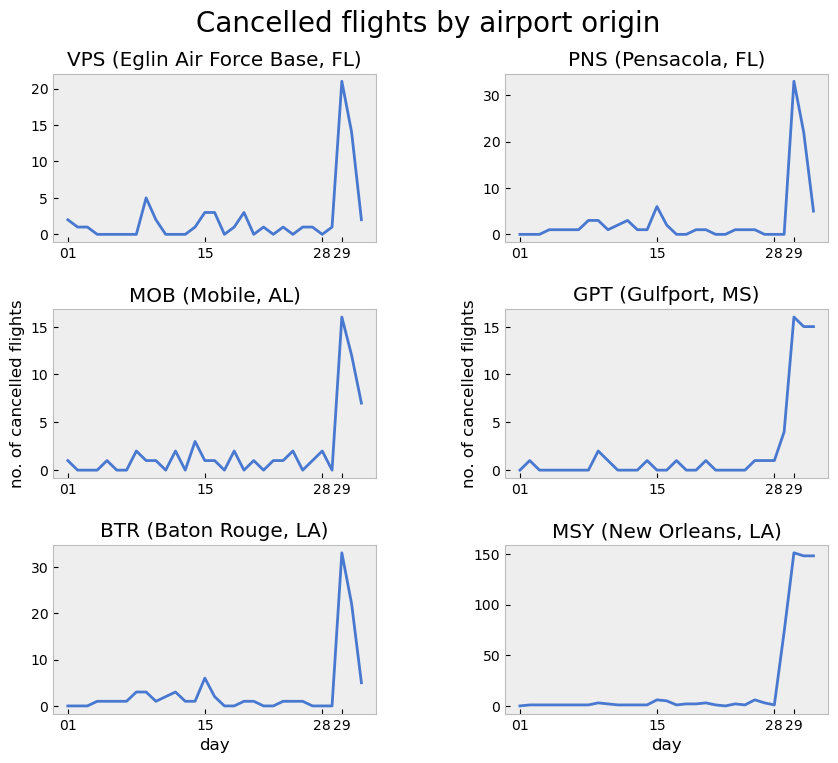

In [ ]:
plt.figure(figsize=(10,8))
plt.suptitle('Cancelled flights by airport origin', fontsize=20)
plt.subplots_adjust(bottom=0.1,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.subplot(3, 2, 1)
plt.plot(VPS_origin_by_date['cancelled'])
plt.title('VPS (Eglin Air Force Base, FL)')
plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '28', '29'])
plt.grid(False)

plt.subplot(3, 2, 2)
plt.plot(PNS_origin_by_date['cancelled'])
plt.title('PNS (Pensacola, FL)')
plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '28', '29'])
plt.grid(False)

plt.subplot(3, 2, 3)  
plt.plot(MOB_origin_by_date['cancelled'])
plt.title('MOB (Mobile, AL)')
plt.ylabel('no. of cancelled flights')
plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '28', '29'])
plt.grid(False)

plt.subplot(3, 2, 4)  
plt.plot(GPT_origin_by_date['cancelled'])
plt.title('GPT (Gulfport, MS)')
plt.ylabel('no. of cancelled flights')
plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '28', '29'])
plt.grid(False)

plt.subplot(3, 2, 5)  
plt.plot(BTR_origin_by_date['cancelled'])
plt.title('BTR (Baton Rouge, LA)')
plt.xlabel('day')
plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '28', '29'])
plt.grid(False)

plt.subplot(3, 2, 6)  
plt.plot(MSY_origin_by_date['cancelled'])
plt.title('MSY (New Orleans, LA)')
plt.xlabel('day')
plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '28', '29'])
plt.grid(False);

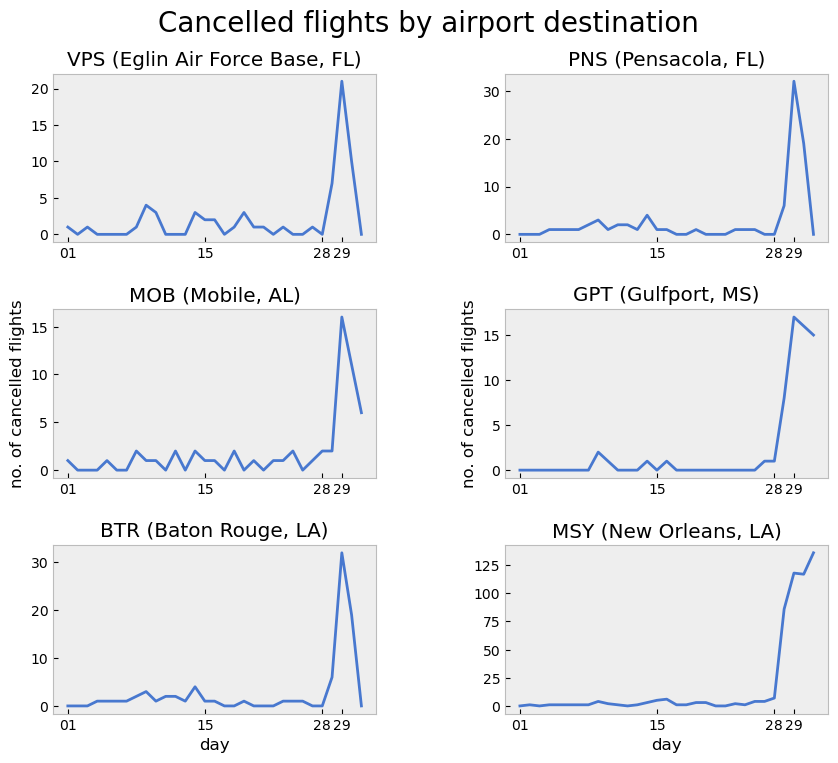

In [ ]:
plt.figure(figsize=(10,8))
plt.suptitle('Cancelled flights by airport destination', fontsize=20)
plt.subplots_adjust(bottom=0.1,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.subplot(3, 2, 1)
plt.plot(VPS_dest_by_date['cancelled'])
plt.title('VPS (Eglin Air Force Base, FL)')
plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '28', '29'])
plt.grid(False)

plt.subplot(3, 2, 2)
plt.plot(PNS_dest_by_date['cancelled'])
plt.title('PNS (Pensacola, FL)')
plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '28', '29'])
plt.grid(False)

plt.subplot(3, 2, 3)  
plt.plot(MOB_dest_by_date['cancelled'])
plt.title('MOB (Mobile, AL)')
plt.ylabel('no. of cancelled flights')
plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '28', '29'])
plt.grid(False)

plt.subplot(3, 2, 4)  
plt.plot(GPT_dest_by_date['cancelled'])
plt.title('GPT (Gulfport, MS)')
plt.ylabel('no. of cancelled flights')
plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '28', '29'])
plt.grid(False)

plt.subplot(3, 2, 5)  
plt.plot(BTR_dest_by_date['cancelled'])
plt.title('BTR (Baton Rouge, LA)')
plt.xlabel('day')
plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '28', '29'])
plt.grid(False)

plt.subplot(3, 2, 6)  
plt.plot(MSY_dest_by_date['cancelled'])
plt.title('MSY (New Orleans, LA)')
plt.xlabel('day')
plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '28', '29'])
plt.grid(False);

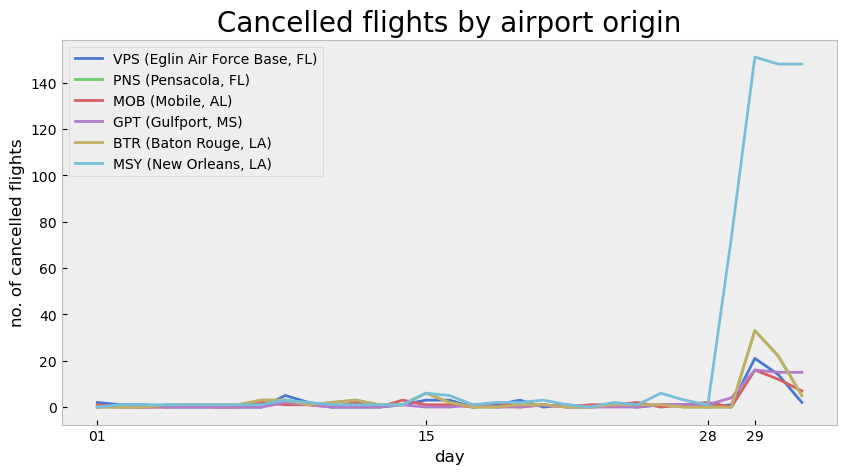

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.title('Cancelled flights by airport origin', fontsize=20)

plt.xlabel('day')
plt.ylabel('no. of cancelled flights')

plt.plot(VPS_origin_by_date['cancelled'], label='VPS (Eglin Air Force Base, FL)')
plt.plot(PNS_origin_by_date['cancelled'], label='PNS (Pensacola, FL)')
plt.plot(MOB_origin_by_date['cancelled'], label='MOB (Mobile, AL)')
plt.plot(GPT_origin_by_date['cancelled'], label='GPT (Gulfport, MS)')
plt.plot(BTR_origin_by_date['cancelled'], label='BTR (Baton Rouge, LA)')
plt.plot(MSY_origin_by_date['cancelled'], label='MSY (New Orleans, LA)')

plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '28', '29'])
plt.legend(loc="upper left")
plt.grid(False)

plt.show();

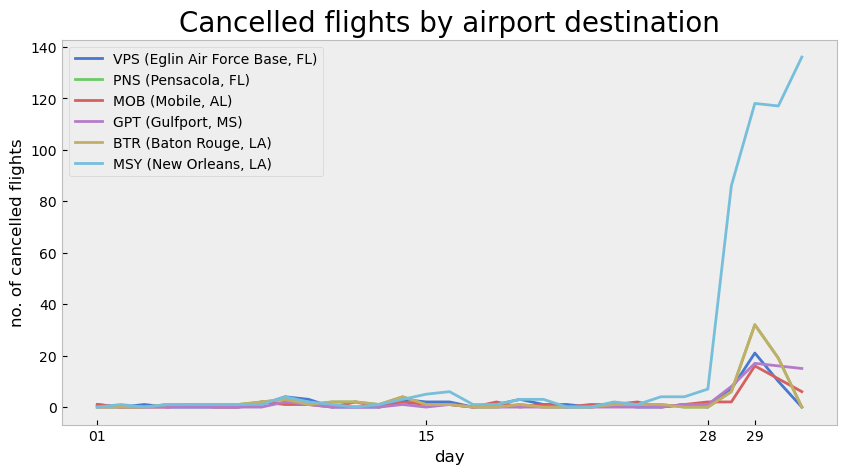

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.title('Cancelled flights by airport destination', fontsize=20)

plt.xlabel('day')
plt.ylabel('no. of cancelled flights')

plt.plot(VPS_dest_by_date['cancelled'], label='VPS (Eglin Air Force Base, FL)')
plt.plot(PNS_dest_by_date['cancelled'], label='PNS (Pensacola, FL)')
plt.plot(MOB_dest_by_date['cancelled'], label='MOB (Mobile, AL)')
plt.plot(GPT_dest_by_date['cancelled'], label='GPT (Gulfport, MS)')
plt.plot(BTR_dest_by_date['cancelled'], label='BTR (Baton Rouge, LA)')
plt.plot(MSY_dest_by_date['cancelled'], label='MSY (New Orleans, LA)')

plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '28', '29'])
plt.legend(loc="upper left")
plt.grid(False)

plt.show();

## weather

### Group by date to calculate means per day

In [ ]:
weather_date = weather_katrina.groupby('date').mean().drop(weather_katrina.columns[[1]], axis=1).reset_index()
weather_date.head(31)

,date,wind_speed_kph,air_pressure_hPa
0,2005-08-01,5.892361,1016.459722
1,2005-08-02,5.477778,1016.064583
2,2005-08-03,7.234028,1015.084028
3,2005-08-04,9.519444,1016.378472
4,2005-08-05,8.889583,1017.487500
5,2005-08-06,11.352083,1016.427778
6,2005-08-07,7.859028,1015.273611
7,2005-08-08,7.670833,1014.868750
8,2005-08-09,7.336806,1015.162500
9,2005-08-10,7.776389,1015.432639


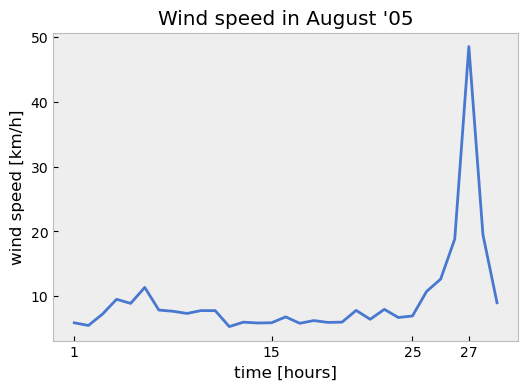

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(weather_date['wind_speed_kph'])

plt.xlabel('time [hours]')
plt.ylabel('wind speed [km/h]')

plt.xticks([0, 14, 24, 28], ['1', '15', '25', '27'])
plt.grid(False)

plt.title("Wind speed in August '05")

plt.show();

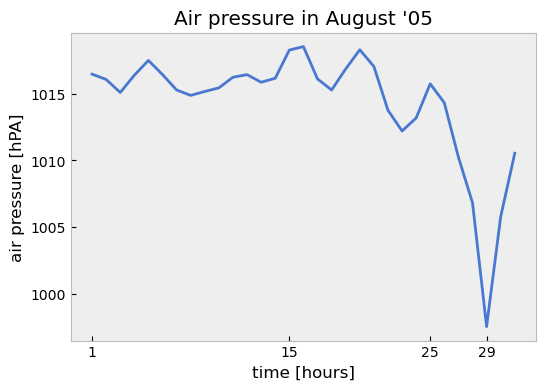

In [ ]:
plt.figure(figsize=(6, 4))

plt.plot(weather_date['air_pressure_hPa'])

plt.xlabel('time [hours]')
plt.ylabel('air pressure [hPA]')

plt.xticks([0, 14, 24, 28], ['1', '15', '25', '29'])
plt.grid(False)

plt.title("Air pressure in August '05")

plt.show();

### Get max wind speed per day & create seperate dataframes for each airport

In [ ]:
max_wind_per_day = get_dataframe(f'SELECT date, (SELECT MAX(wind_speed_kph) AS max_wind_spd), airport_code FROM cgn_analytics_22_3.group_1_weather_hourly GROUP BY date, airport_code ORDER BY date;')
max_wind_per_day.head()

,date,max_wind_spd,airport_code
0,2005-08-01,16.6,MSY
1,2005-08-01,13.0,PNS
2,2005-08-01,13.0,MOB
3,2005-08-01,20.5,BTR
4,2005-08-01,14.8,GPT


In [ ]:
# PNS

PNS_weather_max = max_wind_per_day[(max_wind_per_day['airport_code'] == 'PNS')]

In [ ]:
# MOB

MOB_weather_max = max_wind_per_day[(max_wind_per_day['airport_code'] == 'MOB')]

In [ ]:
# BTR

BTR_weather_max = max_wind_per_day[(max_wind_per_day['airport_code'] == 'BTR')]

In [ ]:
# MSY

MSY_weather_max = max_wind_per_day[(max_wind_per_day['airport_code'] == 'MSY')]

In [ ]:
# VPS

VPS_weather_max = max_wind_per_day[(max_wind_per_day['airport_code'] == 'VPS')]

In [ ]:
# GPT

GPT_weather_max = max_wind_per_day[(max_wind_per_day['airport_code'] == 'GPT')]

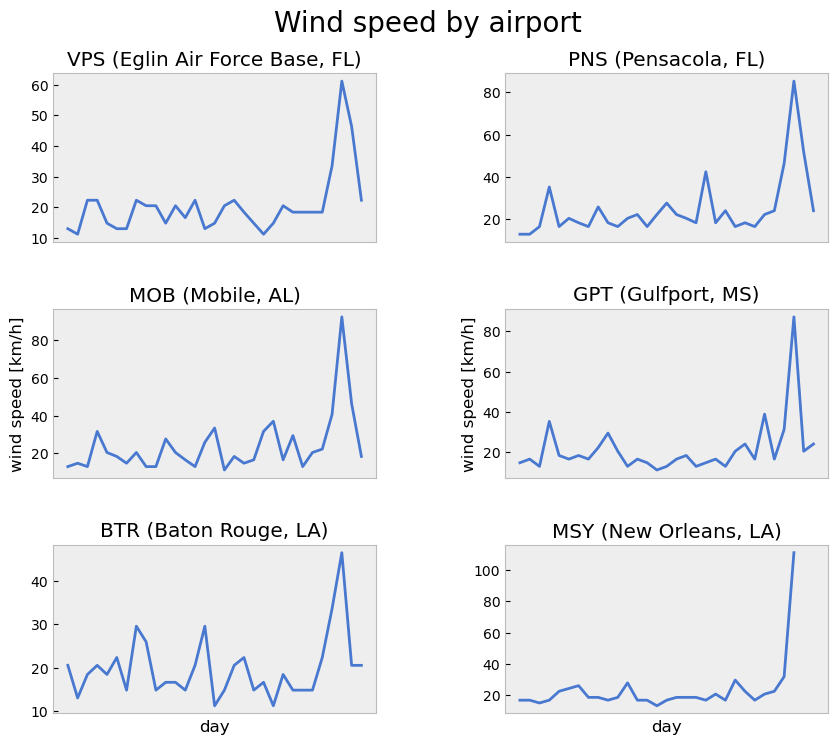

In [ ]:
plt.figure(figsize=(10,8))
plt.suptitle('Wind speed by airport', fontsize=20)
plt.subplots_adjust(bottom=0.1,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.subplot(3, 2, 1)
plt.plot(VPS_weather_max['date'], VPS_weather_max['max_wind_spd'])
plt.title('VPS (Eglin Air Force Base, FL)')
plt.xticks([])
plt.grid(False)

plt.subplot(3, 2, 2)
plt.plot(PNS_weather_max['date'], PNS_weather_max['max_wind_spd'])
plt.title('PNS (Pensacola, FL)')
plt.xticks([])
plt.grid(False)

plt.subplot(3, 2, 3)  
plt.plot(MOB_weather_max['date'], MOB_weather_max['max_wind_spd'])
plt.title('MOB (Mobile, AL)')
plt.ylabel('wind speed [km/h]')
plt.xticks([])
plt.grid(False)

plt.subplot(3, 2, 4)  
plt.plot(GPT_weather_max['date'], GPT_weather_max['max_wind_spd'])
plt.title('GPT (Gulfport, MS)')
plt.ylabel('wind speed [km/h]')
plt.xticks([])
plt.grid(False)

plt.subplot(3, 2, 5)  
plt.plot(BTR_weather_max['date'], BTR_weather_max['max_wind_spd'])
plt.title('BTR (Baton Rouge, LA)')
plt.xlabel('day')
plt.xticks([])
plt.grid(False)

plt.subplot(3, 2, 6)  
plt.plot(MSY_weather_max['date'], MSY_weather_max['max_wind_spd'])
plt.title('MSY (New Orleans, LA)')
plt.xlabel('day')
plt.xticks([])
plt.grid(False);

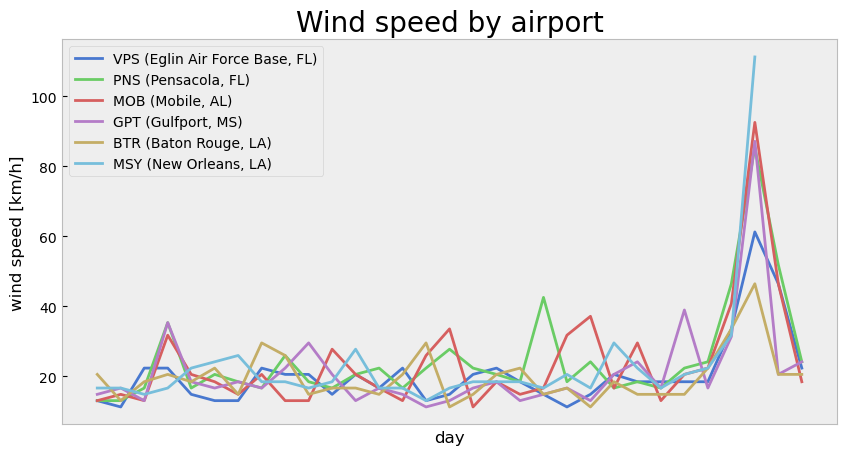

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.title('Wind speed by airport', fontsize=20)

plt.xlabel('day')
plt.ylabel('wind speed [km/h]')

plt.plot(VPS_weather_max['date'], VPS_weather_max['max_wind_spd'], label='VPS (Eglin Air Force Base, FL)')
plt.plot(PNS_weather_max['date'], PNS_weather_max['max_wind_spd'], label='PNS (Pensacola, FL)')
plt.plot(MOB_weather_max['date'], MOB_weather_max['max_wind_spd'], label='MOB (Mobile, AL)')
plt.plot(GPT_weather_max['date'], GPT_weather_max['max_wind_spd'], label='GPT (Gulfport, MS)')
plt.plot(BTR_weather_max['date'], BTR_weather_max['max_wind_spd'], label='BTR (Baton Rouge, LA)')
plt.plot(MSY_weather_max['date'], MSY_weather_max['max_wind_spd'], label='MSY (New Orleans, LA)')

#plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '28', '29'])
plt.legend(loc="upper left")
plt.xticks([])
plt.grid(False)

plt.show();

### Checking hypotheses with pie charts

We take the mean air time, departure delay and the amount of cancelled flights and of diverted flights (for all six airports) for the time before Katrina (from 01-08-2005 to 22-08-2005) and during Katrina (from 23-08-2005 to 31-08-2005). Note: this was already done above and is repeated here for the sake of clarity.

In [1]:
airtime_bk = (before_katrina['air_time']).mean()
airtime_dk = (during_katrina['air_time']).mean()

NameError: name 'before_katrina' is not defined

In [ ]:
delay_bk = (before_katrina['dep_delay']).mean()
delay_dk = (during_katrina['dep_delay']).mean()

In [ ]:
diverted_bk = (before_katrina['diverted'] == 1).sum()
diverted_dk = (during_katrina['diverted'] == 1).sum()

In [ ]:
cancelled_bk = (before_katrina['cancelled'] == 1).sum()
cancelled_dk = (during_katrina['cancelled'] == 1).sum()

We put these variables into a new dataframe that we will use to make pie charts.

In [ ]:
before_vs_during = pd.DataFrame({'cancelled': [cancelled_bk, cancelled_dk],
                   'mean air time': [airtime_bk, airtime_dk],
                   "mean departure delay": [delay_bk, delay_dk],
                   "diverted": [diverted_bk,diverted_dk]},
                  index=['before Katrina', 'during Katrina'])

Now it's time for the pie charts!

In [ ]:
plot = before_vs_during.plot.pie(figsize=(6,6),labels=None,title=("amount of cancelled flights"), y='cancelled')

In [ ]:
plot = before_vs_during.plot.pie(figsize=(6,6),title=("mean airtime"), labels=None,y='mean air time')

In [ ]:
plot = before_vs_during.plot.pie(title=("mean departure delay"),labels=None,y='mean departure delay', figsize=(6, 6))

In [ ]:
plot = before_vs_during.plot.pie(title= ("amount of diverted flights"),labels=None,y='diverted', figsize=(6, 6))

Here we take the Null values for airtime and departure delay to see if it could influence our findings above.

In [ ]:
airtime_nan_bk = before_katrina['air_time'].isna().sum()
airtime_nan_dk = during_katrina['air_time'].isna().sum()

In [ ]:
depdelay_nan_bk = before_katrina['dep_delay'].isna().sum()
depdelay_nan_dk = during_katrina['dep_delay'].isna().sum()

In [ ]:
amount_null = pd.DataFrame({'airtime': [airtime_nan_bk, airtime_nan_dk],
                   "departure delay": [depdelay_nan_bk, depdelay_nan_dk],
                   },
                  index=['before Katrina', 'during Katrina'])

In [ ]:
amount_null.plot.pie(figsize=(6,6),title=("None values airtime"),labels=None, y="airtime")

In [ ]:
amount_null.plot.pie(title=("None values departure delay"),labels=None,y="departure delay",figsize=(6,6) )

# Weather Data

## Retrieving and Cleaning Weather Data from August 2005 (from weather stations near each airport)

In [1]:
from get_weather_data import get_katrina_weather_data as get_kat_data
from get_weather_data import clean_hourly_data

# MSY Airport, New Orleans, Ln

msy_hourly = get_kat_data('29.9893', '-90.2548', 'hourly')
msy_hourly_clean = clean_hourly_data(msy_hourly, 'MSY')


# BTR Airport, Baton Rouge, La

btr_hourly = get_kat_data('30.53236', '-91.151461', 'hourly')
btr_hourly_clean = clean_hourly_data(btr_hourly, 'BTR')


# GPT Airport, Biloxi, Miss

gpt_hourly = get_kat_data('30.413366', '-89.072955', 'hourly')
gpt_hourly_clean = clean_hourly_data(gpt_hourly, 'GPT')


# MOB Airport, Mobile, Ala

mob_hourly = get_kat_data('30.6882', '-88.2390', 'hourly')
mob_hourly_clean = clean_hourly_data(mob_hourly, 'MOB')


# PNS Airport, Pensacola, Fla

pns_hourly = get_kat_data('30.473816', '-87.186705', 'hourly')
pns_hourly_clean = clean_hourly_data(pns_hourly, 'PNS')


# VPS Airport, Eglin Air Force Base, Fla

vps_hourly = get_kat_data('30.495438', '-86.549817', 'hourly')
vps_hourly_clean = clean_hourly_data(vps_hourly, 'VPS')

## Concatenating all weather data

In [5]:
df_weather_all = pd.concat([msy_hourly_clean, btr_hourly_clean, gpt_hourly_clean, mob_hourly_clean, pns_hourly_clean, vps_hourly_clean], axis=0)
df_weather_all.head()

,date,temp_celsius,wind_speed_kph,air_pressure_hPa,airport_code
0,2005-08-01 00:00:00,28.9,9.4,1015.1,MSY
1,2005-08-01 01:00:00,28.3,5.4,1015.8,MSY
2,2005-08-01 02:00:00,28.3,0.0,1016.1,MSY
3,2005-08-01 03:00:00,26.7,5.4,1016.1,MSY
4,2005-08-01 04:00:00,25.6,0.0,1016.2,MSY


## Changing date format of weather data to fit flight data

In [6]:
weather_dates=[]
for i in df_weather_all.date.tolist():
    weather_dates.append(i.split()[0])

weather_dates

df_weather_all.date = weather_dates

In [12]:
df_weather_all.head()

,date,temp_celsius,wind_speed_kph,air_pressure_hPa,airport_code
0,2005-08-01,28.9,9.4,1015.1,MSY
1,2005-08-01,28.3,5.4,1015.8,MSY
2,2005-08-01,28.3,0.0,1016.1,MSY
3,2005-08-01,26.7,5.4,1016.1,MSY
4,2005-08-01,25.6,0.0,1016.2,MSY


## Pushing weather data to SQL database for all group members to work with

In [10]:
from sql_functions import get_engine
from sql_functions import push_to_database
import psycopg2

schema = 'cgn_analytics_22_3'
engine = get_engine()
table_name = 'group_1_weather_hourly'                                                                                     

push_to_database(df=df_weather_all, table_name=table_name, engine=engine, schema=schema)

The group_1_weather_hourly table was imported successfully.


## Extract dataframe from weather table with max wind speeds per day and airport from SQL database

In [14]:
from sql_functions import get_dataframe

df_max_wind_per_day = get_dataframe(f'SELECT date, (SELECT MAX(wind_speed_kph) AS max_wind_spd), airport_code FROM {schema}.group_1_weather_hourly GROUP BY date, airport_code ORDER BY date;')

df_max_wind_per_day.head()

,date,max_wind_spd,airport_code
0,2005-08-01,16.6,MSY
1,2005-08-01,13.0,PNS
2,2005-08-01,13.0,MOB
3,2005-08-01,20.5,BTR
4,2005-08-01,14.8,GPT


## Plotting max wind speeds per day

### For every Airport

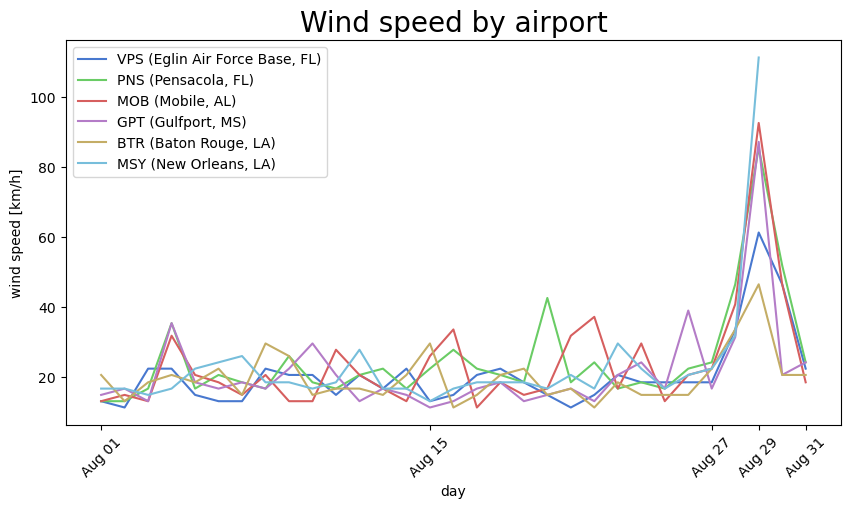

In [18]:
plt.style.use('seaborn-muted')
fig = plt.figure(figsize=(10,5))
plt.title('Wind speed by airport', fontsize=20)

plt.xlabel('day')
plt.ylabel('wind speed [km/h]')

plt.plot(df_max_wind_per_day.date[df_max_wind_per_day.airport_code == 'VPS'], df_max_wind_per_day.max_wind_spd[df_max_wind_per_day.airport_code == 'VPS'], label='VPS (Eglin Air Force Base, FL)')
plt.plot(df_max_wind_per_day.date[df_max_wind_per_day.airport_code == 'PNS'], df_max_wind_per_day.max_wind_spd[df_max_wind_per_day.airport_code == 'PNS'], label='PNS (Pensacola, FL)')
plt.plot(df_max_wind_per_day.date[df_max_wind_per_day.airport_code == 'MOB'], df_max_wind_per_day.max_wind_spd[df_max_wind_per_day.airport_code == 'MOB'], label='MOB (Mobile, AL)')
plt.plot(df_max_wind_per_day.date[df_max_wind_per_day.airport_code == 'GPT'], df_max_wind_per_day.max_wind_spd[df_max_wind_per_day.airport_code == 'GPT'], label='GPT (Gulfport, MS)')
plt.plot(df_max_wind_per_day.date[df_max_wind_per_day.airport_code == 'BTR'], df_max_wind_per_day.max_wind_spd[df_max_wind_per_day.airport_code == 'BTR'], label='BTR (Baton Rouge, LA)')
plt.plot(df_max_wind_per_day.date[df_max_wind_per_day.airport_code == 'MSY'], df_max_wind_per_day.max_wind_spd[df_max_wind_per_day.airport_code == 'MSY'], label='MSY (New Orleans, LA)')

plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29', '2005-08-31'], ['Aug 01', 'Aug 15', 'Aug 27', 'Aug 29', 'Aug 31'], rotation=45)
plt.legend(loc="upper left")
plt.grid(False)

plt.show();

### For MSY and BTR only (highest and lowest peak wind speed)

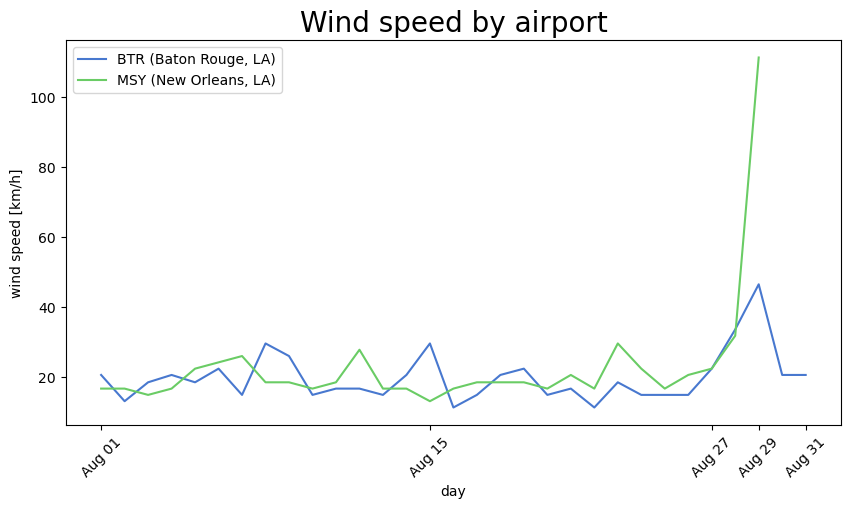

In [19]:
fig = plt.figure(figsize=(10,5))
plt.title('Wind speed by airport', fontsize=20)

plt.xlabel('day')
plt.ylabel('wind speed [km/h]')

plt.plot(df_max_wind_per_day.date[df_max_wind_per_day.airport_code == 'BTR'], df_max_wind_per_day.max_wind_spd[df_max_wind_per_day.airport_code == 'BTR'], label='BTR (Baton Rouge, LA)')
plt.plot(df_max_wind_per_day.date[df_max_wind_per_day.airport_code == 'MSY'], df_max_wind_per_day.max_wind_spd[df_max_wind_per_day.airport_code == 'MSY'], label='MSY (New Orleans, LA)')

plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29', '2005-08-31'], ['Aug 01', 'Aug 15', 'Aug 27', 'Aug 29', 'Aug 31'], rotation=45)
plt.legend(loc="upper left")
plt.grid(False)

plt.show();

## Plotting number of cancelled flights by origin airport

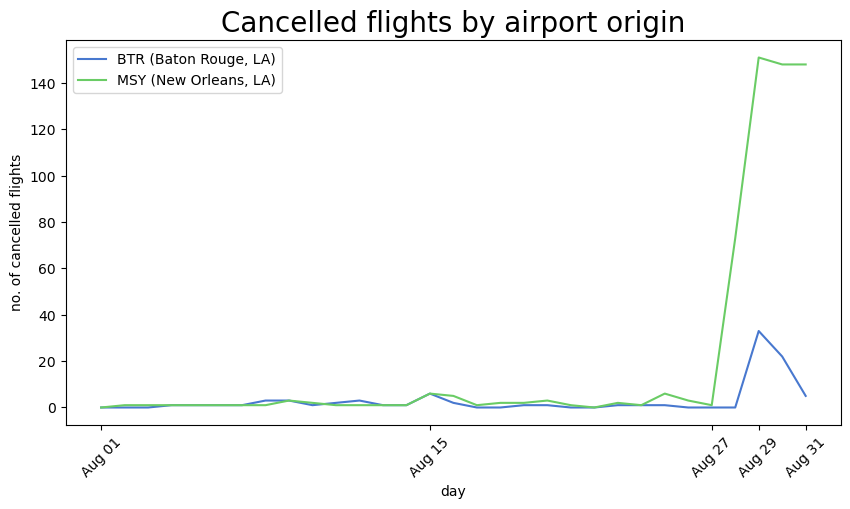

In [29]:
fig = plt.figure(figsize=(10,5))
plt.title('Cancelled flights by origin airport', fontsize=20)

plt.xlabel('day')
plt.ylabel('no. of cancelled flights')

plt.plot(BTR_origin_by_date['cancelled'], label='BTR (Baton Rouge, LA)')
plt.plot(MSY_origin_by_date['cancelled'], label='MSY (New Orleans, LA)')

plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29', '2005-08-31'], ['Aug 01', 'Aug 15', 'Aug 27', 'Aug 29', 'Aug 31'], rotation=45)
plt.legend(loc="upper left")
plt.grid(False)

plt.show();